# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import time
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from dqn_agent import DQNAgent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
def dqnrunner(agent, 
              n_episodes=2000, 
              max_t=1000, 
              eps_start=1.0, 
              eps_end=0.01, 
              eps_decay=0.995, 
              train = True, 
              stable_episode_count = 100, 
              target_score = 13, 
              print_every = 10):
    """
    Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train(bool): whether to train or run
        stable_episode_count (int): number episodes the scores should average to target_score
        target_score(float): score at which we consider the environment is solved.
        print_every(int): Number of eisodes we print the debug/log information.
    """
    scores = []                        # list containing scores from each episode
    scores_deque = deque(maxlen=stable_episode_count)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    episodes_start = time.time()
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]
        # examine the state space 
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):
            action = agent.act(state, eps if train else 0.0)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            if train:
                agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        scores_deque.append(score)                        # save most recent score
        scores.append(score)                               # save most recent score
        eps = max(eps_end, eps_decay*eps)                  # decrease epsilon
        
        if np.mean(scores_deque) <= target_score:
            if i_episode % print_every == 0:
                episodes_end = time.time()
                print('\rEpisode {}\tAverage score in the latest {} episodes: \
                      {}'.format(i_episode, i_episode if i_episode <= stable_episode_count \
                                 else stable_episode_count, np.mean(scores_deque)))
                print('\rLast {} episodes took {} seconds'.format(print_every, episodes_end - episodes_start))
                episodes_start = time.time()
        else:
            print('\rEpisode {}\tAverage score in the latest {} episodes: \
                    {}'.format(i_episode, i_episode if i_episode <= stable_episode_count \
                               else stable_episode_count, np.mean(scores_deque)))
            print('\r\rThe score average is over {} in the last {} episodes. \
                    Stop the training.'.format(target_score, stable_episode_count))
            if train:
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
                break
    
    return scores

In [7]:
def plotGraphs(scorelist, cols = 2, rows = 4, size = (16, 9)):
    '''
    Display images in a grid
    '''
    
    number_of_images = len(scorelist)
    
    if (rows == 1 and cols == 1):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scorelist[0])), scorelist[0])
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
    else:
        figure, axes = plt.subplots(rows, cols, figsize = size)
        indices = range(number_of_images)
        figure.subplots_adjust(hspace = 0.5)
        print(axes)
        axeslist = [item for item in axes]
        for ax, index in zip(axeslist, indices):
            np.delete(axeslist, 0, 0)
            if index < number_of_images:
                ax.plot(np.arange(1, len(scorelist[index])+1), scorelist[index])
                ax.set_title("Batch_size: " + str(batch_sizes[index]))
                ax.set_xlabel("Episode #")
                ax.set_ylabel("Score")

In [8]:
# Final Run

start = time.time()

batch_sizes = [32]

scorelist = []
batch_times = []

for batch_size in batch_sizes:
    loopstart = time.time()
    dqnagent = DQNAgent(state_size=state_size, action_size=action_size, seed=17, BATCH_SIZE=batch_size)
    scores = dqnrunner(dqnagent, print_every=40, stable_episode_count=100, target_score=13)
    scorelist.append(scores)
    loopend = time.time()
    print("\rBatch size: ", batch_size, " took ", loopend - loopstart, " seconds.\n")
    batch_times.append(loopend - loopstart)

end = time.time()
print('Elapsed ', end - start, ' seconds.')

Episode 40	Average score in the latest 40 episodes:                       0.3
Last 40 episodes took 105.6323549747467 seconds
Episode 80	Average score in the latest 80 episodes:                       0.2125
Last 40 episodes took 102.84223318099976 seconds
Episode 120	Average score in the latest 100 episodes:                       0.89
Last 40 episodes took 100.3390760421753 seconds
Episode 160	Average score in the latest 100 episodes:                       2.49
Last 40 episodes took 103.4911208152771 seconds
Episode 200	Average score in the latest 100 episodes:                       4.33
Last 40 episodes took 102.68385338783264 seconds
Episode 240	Average score in the latest 100 episodes:                       5.32
Last 40 episodes took 102.34631204605103 seconds
Episode 280	Average score in the latest 100 episodes:                       6.33
Last 40 episodes took 104.10608053207397 seconds
Episode 320	Average score in the latest 100 episodes:                       7.17
Last 40 episode

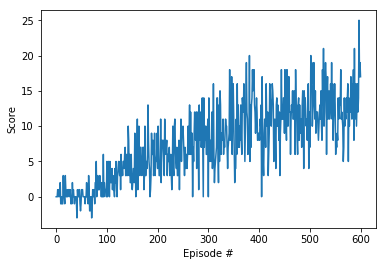

In [9]:
plotGraphs(scorelist, cols = 1, rows = 1)

In [10]:
dqnagent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

In [11]:
scores = dqnrunner(dqnagent, n_episodes=20, train=False)

Episode 1	Average score in the latest 1 episodes:                     17.0
The score average is over 13 in the last 100 episodes.                     Stop the training.
Episode 2	Average score in the latest 2 episodes:                     15.5
The score average is over 13 in the last 100 episodes.                     Stop the training.
Episode 3	Average score in the latest 3 episodes:                     13.666666666666666
The score average is over 13 in the last 100 episodes.                     Stop the training.
Episode 4	Average score in the latest 4 episodes:                     14.25
The score average is over 13 in the last 100 episodes.                     Stop the training.
Episode 5	Average score in the latest 5 episodes:                     14.4
The score average is over 13 in the last 100 episodes.                     Stop the training.
Episode 6	Average score in the latest 6 episodes:                     14.166666666666666
The score average is over 13 in the last 100 episod

In [12]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = dqnagent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 11.0


When finished, you can close the environment.

In [13]:
env.close()